In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display, HTML
import seaborn as sns

# Set nicer plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# 1. Load and Preprocess Data
print("Loading datasets...")
ratings_df = pd.read_csv('ratings.csv')  # MovieLens small dataset
movies_df = pd.read_csv('movies.csv')  # Load movie data right away

print(f"Dataset loaded: {len(ratings_df)} ratings, {len(movies_df)} movies")

user_ids = ratings_df['userId'].unique()
movie_ids = ratings_df['movieId'].unique()
user_id_map = {id: idx for idx, id in enumerate(user_ids)}
movie_id_map = {id: idx for idx, id in enumerate(movie_ids)}

ratings_df['userIdx'] = ratings_df['userId'].map(user_id_map)
ratings_df['movieIdx'] = ratings_df['movieId'].map(movie_id_map)
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)

print(f"Number of users: {len(user_ids)}, Number of movies: {len(movie_ids)}")
print(f"Training set: {len(train_df)} ratings, Test set: {len(test_df)} ratings")

# Display sample of data
print("\nSample of ratings data:")
display(ratings_df.head())

print("\nSample of movies data:")
display(movies_df.head())

# 2. Initialize Parameters
print("\n" + "="*50)
print("Initializing model parameters...")
print("="*50)

NUM_USERS = len(user_ids)
NUM_MOVIES = len(movie_ids)
EMBEDDING_DIM = 10  # Size of embedding vectors
LEARNING_RATE = 0.01
REGULARIZATION = 0.01  # L2 regularization to prevent overfitting
EPOCHS = 20

print(f"Model configuration:")
print(f"- Embedding dimension: {EMBEDDING_DIM}")
print(f"- Learning rate: {LEARNING_RATE}")
print(f"- Regularization: {REGULARIZATION}")
print(f"- Epochs: {EPOCHS}")

# Randomly initialize user and movie embeddings
np.random.seed(42)
initial_user_embeddings = np.random.normal(0, 0.1, (NUM_USERS, EMBEDDING_DIM))
initial_movie_embeddings = np.random.normal(0, 0.1, (NUM_MOVIES, EMBEDDING_DIM))

# Create copies for training
user_embeddings = initial_user_embeddings.copy()
movie_embeddings = initial_movie_embeddings.copy()

# Function to find similar movies based on embeddings
def find_similar_movies(movie_title, movie_emb, top_n=5):
    """Find movies similar to the given movie title based on embedding similarity."""
    # Find the movie ID for the given title
    movie_row = movies_df[movies_df['title'].str.contains(movie_title, case=False)]
    if movie_row.empty:
        return f"Movie '{movie_title}' not found."
    
    movie_id = movie_row.iloc[0]['movieId']
    if movie_id not in movie_id_map:
        return f"Movie '{movie_title}' has no ratings data."
    
    # Get the movie embedding
    movie_idx = movie_id_map[movie_id]
    target_embedding = movie_emb[movie_idx].reshape(1, -1)
    
    # Calculate similarity to all other movies
    similarities = []
    for idx, mid in enumerate(movie_id_map.keys()):
        if idx != movie_idx:  # Skip the target movie itself
            sim = cosine_similarity(target_embedding, movie_emb[idx].reshape(1, -1))[0][0]
            similarities.append((mid, sim))
    
    # Sort by similarity (highest first)
    similarities.sort(key=lambda x: x[1], reverse=True)
    
    # Get movie info for top similar movies
    result = []
    for mid, sim in similarities[:top_n]:
        movie_info = movies_df[movies_df['movieId'] == mid]
        if not movie_info.empty:
            result.append({
                'movieId': mid,
                'title': movie_info.iloc[0]['title'],
                'genres': movie_info.iloc[0]['genres'],
                'similarity': sim
            })
    
    return pd.DataFrame(result)

# Function to get movie title from movie ID
def get_movie_title(movie_id):
    movie_info = movies_df[movies_df['movieId'] == movie_id]
    if not movie_info.empty:
        return movie_info.iloc[0]['title']
    return "Unknown"

# Function to compute MSE on test set
def compute_test_loss(test_data, user_emb, movie_emb):
    total_loss = 0
    for _, row in test_data.iterrows():
        user_idx = int(row['userIdx'])
        movie_idx = int(row['movieIdx'])
        rating = row['rating']
        pred_rating = np.dot(user_emb[user_idx], movie_emb[movie_idx])
        total_loss += (rating - pred_rating) ** 2
    return total_loss / len(test_data)

# Example movies to track similarities before and after training
print("\n" + "="*50)
print("Analyzing initial movie similarities (before training)...")
print("="*50)

example_movies = ["Star Wars", "Toy Story", "The Godfather", "Pulp Fiction", "The Matrix"]

# Check and find valid movies from our examples
valid_example_movies = []
for movie in example_movies:
    found = not movies_df[movies_df['title'].str.contains(movie, case=False)].empty
    if found:
        valid_example_movies.append(movie)
    else:
        print(f"Movie '{movie}' not found in dataset, skipping.")

if not valid_example_movies:
    valid_example_movies = [
        movies_df.iloc[0]['title'],  # Just use the first movie if none of our examples are found
        movies_df.iloc[1]['title']   # And a second one
    ]
    print(f"Using {valid_example_movies} as example movies instead.")

# Find similar movies before training
before_similarities = {}
for movie in valid_example_movies:
    print(f"\nMovies similar to '{movie}' BEFORE training:")
    similar = find_similar_movies(movie, initial_movie_embeddings)
    before_similarities[movie] = similar
    display(similar)

Loading datasets...
Dataset loaded: 100836 ratings, 9742 movies
Number of users: 610, Number of movies: 9724
Training set: 80668 ratings, Test set: 20168 ratings

Sample of ratings data:


,userId,movieId,rating,timestamp,userIdx,movieIdx
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4



Sample of movies data:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



Initializing model parameters...
Model configuration:
- Embedding dimension: 10
- Learning rate: 0.01
- Regularization: 0.01
- Epochs: 20

Analyzing initial movie similarities (before training)...
Movie 'The Matrix' not found in dataset, skipping.

Movies similar to 'Star Wars' BEFORE training:


,movieId,title,genres,similarity
0,436,Color of Night (1994),Drama|Thriller,0.923731
1,512,"Puppet Masters, The (1994)",Horror|Sci-Fi,0.894711
2,3758,Communion (1989),Drama|Sci-Fi|Thriller,0.884070
3,6851,"Gas, Food, Lodging (1992)",Drama|Romance,0.861796
4,32770,Brothers (Brødre) (2004),Drama,0.860112



Movies similar to 'Toy Story' BEFORE training:


,movieId,title,genres,similarity
0,615,Bread and Chocolate (Pane e cioccolata) (1973),Comedy|Drama,0.916275
1,171765,Okja (2017),Action|Adventure|Drama|Sci-Fi,0.879531
2,5489,Nosferatu the Vampyre (Nosferatu: Phantom der ...,Horror,0.876887
3,1641,"Full Monty, The (1997)",Comedy|Drama,0.876424
4,1991,Child's Play (1988),Horror|Thriller,0.839784



Movies similar to 'The Godfather' BEFORE training:


,movieId,title,genres,similarity
0,109895,Bad Words (2013),Comedy,0.911402
1,1713,Mouse Hunt (1997),Children|Comedy,0.911351
2,45074,"Wild, The (2006)",Adventure|Animation|Children|Comedy|Fantasy,0.881848
3,5264,Clockstoppers (2002),Action|Adventure|Sci-Fi|Thriller,0.861121
4,3445,Eyes of Laura Mars (1978),Mystery|Thriller,0.857755



Movies similar to 'Pulp Fiction' BEFORE training:


,movieId,title,genres,similarity
0,4835,Coal Miner's Daughter (1980),Drama,0.920592
1,2921,High Plains Drifter (1973),Western,0.902821
2,3211,"Cry in the Dark, A (1988)",Drama,0.865535
3,73854,"Rudolph, the Red-Nosed Reindeer (1964)",Adventure|Animation|Children|Fantasy|Musical,0.863723
4,3799,Pokémon the Movie 2000 (2000),Animation|Children,0.848668



Training model...
Epoch 1/20, Train Loss: 13.2189, Test Loss: 12.3041
Epoch 2/20, Train Loss: 6.9625, Test Loss: 3.7317
Epoch 3/20, Train Loss: 2.5469, Test Loss: 2.2778
Epoch 4/20, Train Loss: 1.5971, Test Loss: 1.8155
Epoch 5/20, Train Loss: 1.2047, Test Loss: 1.6054
Epoch 6/20, Train Loss: 0.9902, Test Loss: 1.4927
Epoch 7/20, Train Loss: 0.8562, Test Loss: 1.4258
Epoch 8/20, Train Loss: 0.7664, Test Loss: 1.3834
Epoch 9/20, Train Loss: 0.7029, Test Loss: 1.3553
Epoch 10/20, Train Loss: 0.6552, Test Loss: 1.3363
Epoch 11/20, Train Loss: 0.6173, Test Loss: 1.3234
Epoch 12/20, Train Loss: 0.5859, Test Loss: 1.3146
Epoch 13/20, Train Loss: 0.5592, Test Loss: 1.3089
Epoch 14/20, Train Loss: 0.5361, Test Loss: 1.3054
Epoch 15/20, Train Loss: 0.5156, Test Loss: 1.3035
Epoch 16/20, Train Loss: 0.4975, Test Loss: 1.3028
Epoch 17/20, Train Loss: 0.4812, Test Loss: 1.3029
Epoch 18/20, Train Loss: 0.4666, Test Loss: 1.3037
Epoch 19/20, Train Loss: 0.4535, Test Loss: 1.3049
Epoch 20/20, Train 

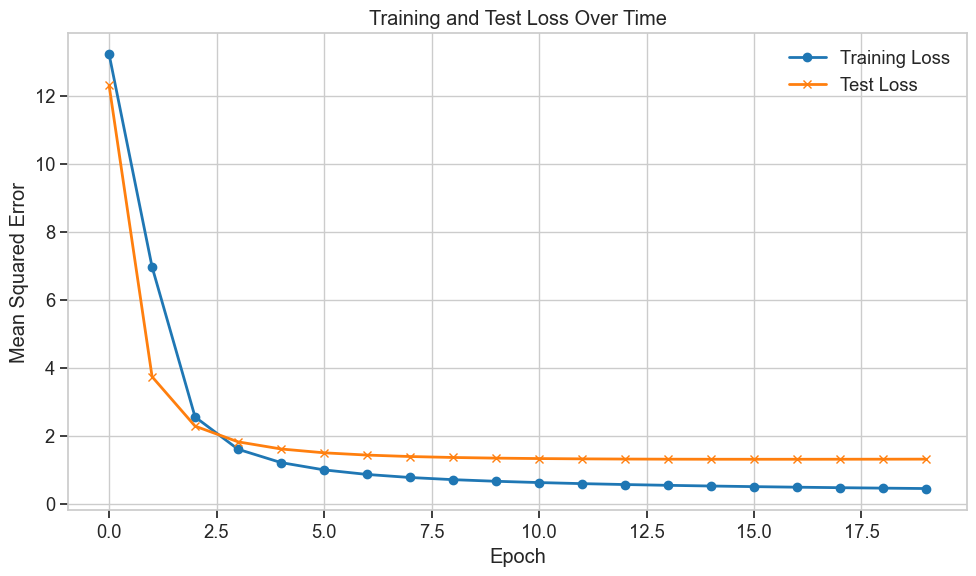


Analyzing movie similarities AFTER training...

Movies similar to 'Star Wars' AFTER training:


,movieId,title,genres,similarity
0,1994,Poltergeist (1982),Horror|Thriller,0.967473
1,13,Balto (1995),Adventure|Animation|Children,0.959503
2,6620,American Splendor (2003),Comedy|Drama,0.957243
3,5788,All or Nothing (2002),Drama,0.954857
4,224,Don Juan DeMarco (1995),Comedy|Drama|Romance,0.954263



Movies similar to 'Toy Story' AFTER training:


,movieId,title,genres,similarity
0,2081,"Little Mermaid, The (1989)",Animation|Children|Comedy|Musical|Romance,0.975422
1,4040,Don't Tell Mom the Babysitter's Dead (1991),Comedy,0.971157
2,112,Rumble in the Bronx (Hont faan kui) (1995),Action|Adventure|Comedy|Crime,0.970199
3,477,What's Love Got to Do with It? (1993),Drama|Musical,0.970089
4,708,"Truth About Cats & Dogs, The (1996)",Comedy|Romance,0.969972



Movies similar to 'The Godfather' AFTER training:


,movieId,title,genres,similarity
0,8955,Undertow (2004),Crime|Drama|Thriller,0.817709
1,118834,National Lampoon's Bag Boy (2007),Comedy,0.800904
2,146662,Dragons: Gift of the Night Fury (2011),Adventure|Animation|Comedy,0.787909
3,95193,Pocahontas II: Journey to a New World (1998),Adventure|Animation|Children,0.692976
4,69304,Imagine That (2009),Comedy|Drama|Fantasy,0.691517



Movies similar to 'Pulp Fiction' AFTER training:


,movieId,title,genres,similarity
0,968,Night of the Living Dead (1968),Horror|Sci-Fi|Thriller,0.970907
1,16,Casino (1995),Crime|Drama,0.956351
2,2951,"Fistful of Dollars, A (Per un pugno di dollari...",Action|Western,0.952980
3,3503,Solaris (Solyaris) (1972),Drama|Mystery|Sci-Fi,0.951804
4,101529,"Brass Teapot, The (2012)",Comedy|Fantasy|Thriller,0.950303



Comparing recommendations before and after training...

=== Comparison for 'Star Wars' ===


,Before Training,Before Similarity,After Training,After Similarity
0,Color of Night (1994),0.924,Poltergeist (1982),0.967
1,"Puppet Masters, The (1994)",0.895,Balto (1995),0.960
2,Communion (1989),0.884,American Splendor (2003),0.957
3,"Gas, Food, Lodging (1992)",0.862,All or Nothing (2002),0.955
4,Brothers (Brødre) (2004),0.860,Don Juan DeMarco (1995),0.954


Overlap in recommendations: 0 out of 5

=== Comparison for 'Toy Story' ===


,Before Training,Before Similarity,After Training,After Similarity
0,Bread and Chocolate (Pane e cioccolata) (1973),0.916,"Little Mermaid, The (1989)",0.975
1,Okja (2017),0.880,Don't Tell Mom the Babysitter's Dead (1991),0.971
2,Nosferatu the Vampyre (Nosferatu: Phantom der ...,0.877,Rumble in the Bronx (Hont faan kui) (1995),0.970
3,"Full Monty, The (1997)",0.876,What's Love Got to Do with It? (1993),0.970
4,Child's Play (1988),0.840,"Truth About Cats & Dogs, The (1996)",0.970


Overlap in recommendations: 0 out of 5

=== Comparison for 'The Godfather' ===


,Before Training,Before Similarity,After Training,After Similarity
0,Bad Words (2013),0.911,Undertow (2004),0.818
1,Mouse Hunt (1997),0.911,National Lampoon's Bag Boy (2007),0.801
2,"Wild, The (2006)",0.882,Dragons: Gift of the Night Fury (2011),0.788
3,Clockstoppers (2002),0.861,Pocahontas II: Journey to a New World (1998),0.693
4,Eyes of Laura Mars (1978),0.858,Imagine That (2009),0.692


Overlap in recommendations: 0 out of 5

=== Comparison for 'Pulp Fiction' ===


,Before Training,Before Similarity,After Training,After Similarity
0,Coal Miner's Daughter (1980),0.921,Night of the Living Dead (1968),0.971
1,High Plains Drifter (1973),0.903,Casino (1995),0.956
2,"Cry in the Dark, A (1988)",0.866,"Fistful of Dollars, A (Per un pugno di dollari...",0.953
3,"Rudolph, the Red-Nosed Reindeer (1964)",0.864,Solaris (Solyaris) (1972),0.952
4,Pokémon the Movie 2000 (2000),0.849,"Brass Teapot, The (2012)",0.950


Overlap in recommendations: 0 out of 5

Finding movies with largest embedding changes...

Movies with largest embedding changes during training:


,movieId,title,genres,change
0,1097,E.T. the Extra-Terrestrial (1982),Children|Drama|Sci-Fi,1.898470
1,5816,Harry Potter and the Chamber of Secrets (2002),Adventure|Fantasy,1.880925
2,333,Tommy Boy (1995),Comedy,1.868887
3,2028,Saving Private Ryan (1998),Action|Drama|War,1.837118
4,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,1.814253
5,736,Twister (1996),Action|Adventure|Romance|Thriller,1.806983
6,177593,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama,1.803187
7,356,Forrest Gump (1994),Comedy|Drama|Romance|War,1.793341
8,1387,Jaws (1975),Action|Horror,1.793104
9,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1.790900


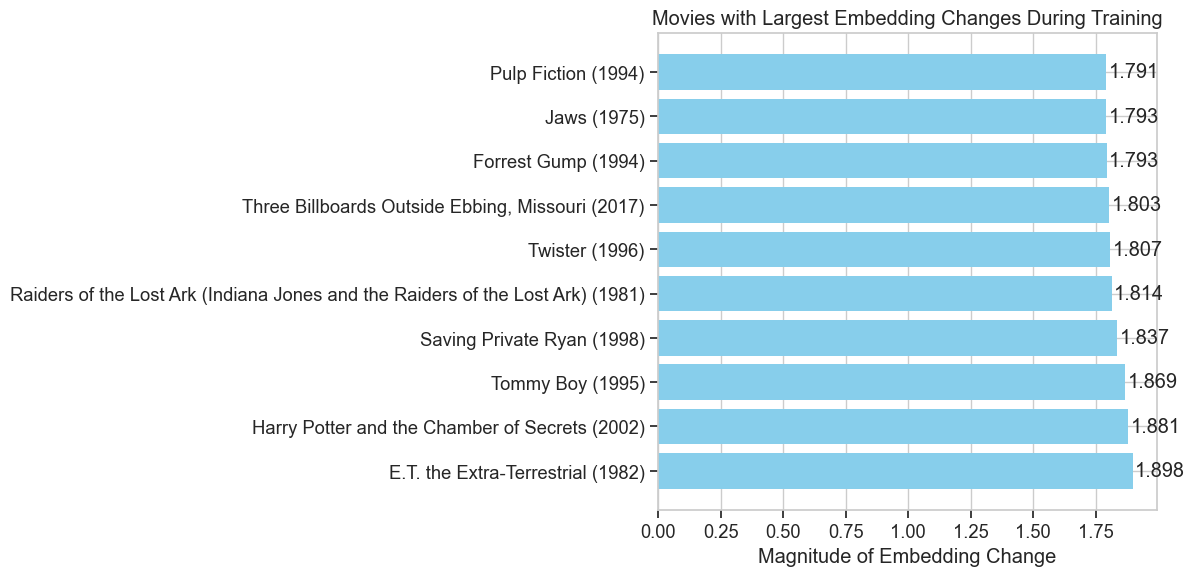


Analyzing similarity changes for movies with largest embedding shifts...

=== Movie with large embedding change: 'E.T. the Extra-Terrestrial (1982)' ===
Change magnitude: 1.898

Similar movies BEFORE vs AFTER training:


,Before Training,Before Similarity,After Training,After Similarity
0,Predator 2 (1990),0.929,Snow White and the Seven Dwarfs (1937),0.958
1,Crows Zero (Kurôzu zero) (2007),0.888,White Man's Burden (1995),0.948
2,Coffy (1973),0.875,Nell (1994),0.944
3,Dragon Ball Z: Broly Second Coming (Doragon bô...,0.858,Close Encounters of the Third Kind (1977),0.941
4,Maria Bamford: The Special Special Special! (2...,0.856,Apollo 13 (1995),0.937


Movies in common before/after: 0 out of 5
Number of recommendations that changed: 5

Genres in similar movies BEFORE training: Thriller, Crime, Action, Animation, Sci-Fi, Comedy, Adventure
Genres in similar movies AFTER training: Drama, Animation, Musical, Sci-Fi, Children, IMAX, Fantasy, Adventure


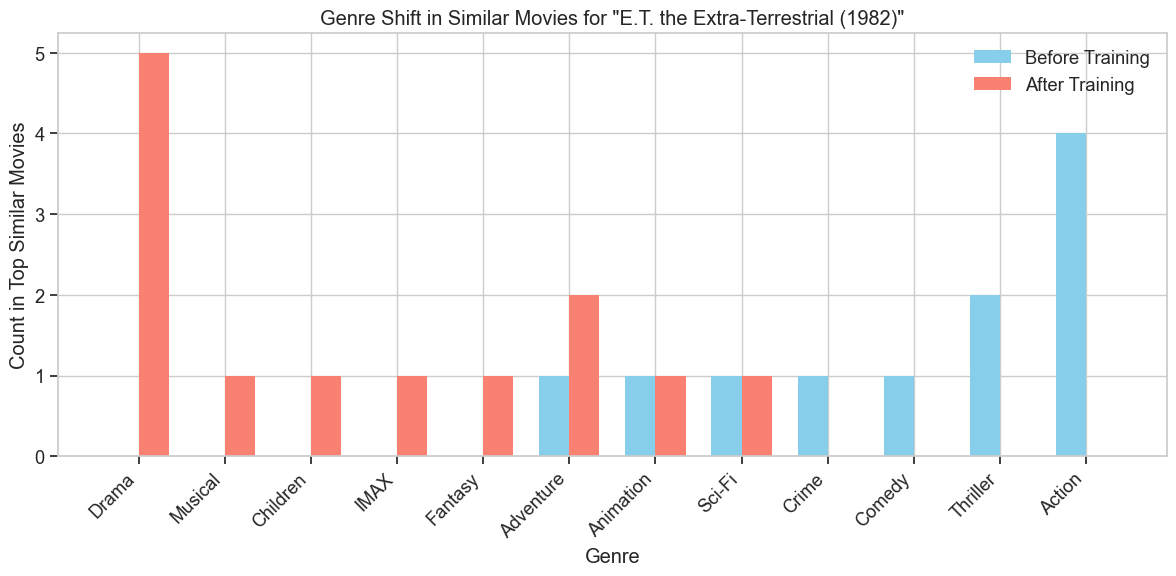


=== Movie with large embedding change: 'Harry Potter and the Chamber of Secrets (2002)' ===
Change magnitude: 1.881

Similar movies BEFORE vs AFTER training:


,Before Training,Before Similarity,After Training,After Similarity
0,Red Planet (2000),0.952,Harry Potter and the Sorcerer's Stone (a.k.a. ...,0.965
1,Mississippi Masala (1991),0.887,Harry Potter and the Order of the Phoenix (2007),0.958
2,Dial M for Murder (1954),0.861,Kazaam (1996),0.951
3,"Invention of Lying, The (2009)",0.844,Night at the Museum (2006),0.945
4,Soapdish (1991),0.838,Liar Liar (1997),0.943


Movies in common before/after: 0 out of 5
Number of recommendations that changed: 5

Genres in similar movies BEFORE training: Romance, Drama, Thriller, Action, Crime, Mystery, Sci-Fi, Comedy
Genres in similar movies AFTER training: Drama, Action, Comedy, Children, IMAX, Fantasy, Adventure


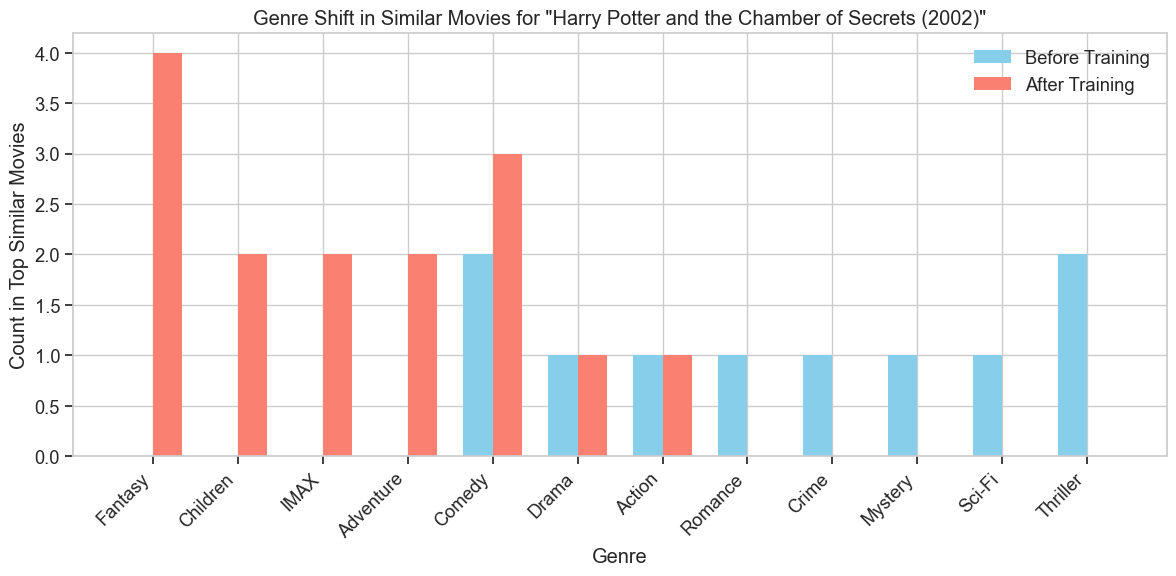


=== Movie with large embedding change: 'Tommy Boy (1995)' ===
Change magnitude: 1.869

Similar movies BEFORE vs AFTER training:


,Before Training,Before Similarity,After Training,After Similarity
0,2001 Maniacs (2005),0.912,Forrest Gump (1994),0.923
1,Prime Suspect 3 (1993),0.911,Jade (1995),0.910
2,"Village, The (2004)",0.888,"Santa Clause, The (1994)",0.909
3,"Men Who Stare at Goats, The (2009)",0.854,I.Q. (1994),0.908
4,Venus in Fur (La Vénus à la fourrure) (2013),0.854,Death Becomes Her (1992),0.906


Movies in common before/after: 0 out of 5
Number of recommendations that changed: 5

Genres in similar movies BEFORE training: Horror, Drama, Crime, Thriller, Action, Mystery, Comedy
Genres in similar movies AFTER training: Romance, Drama, Thriller, War, Comedy, Fantasy


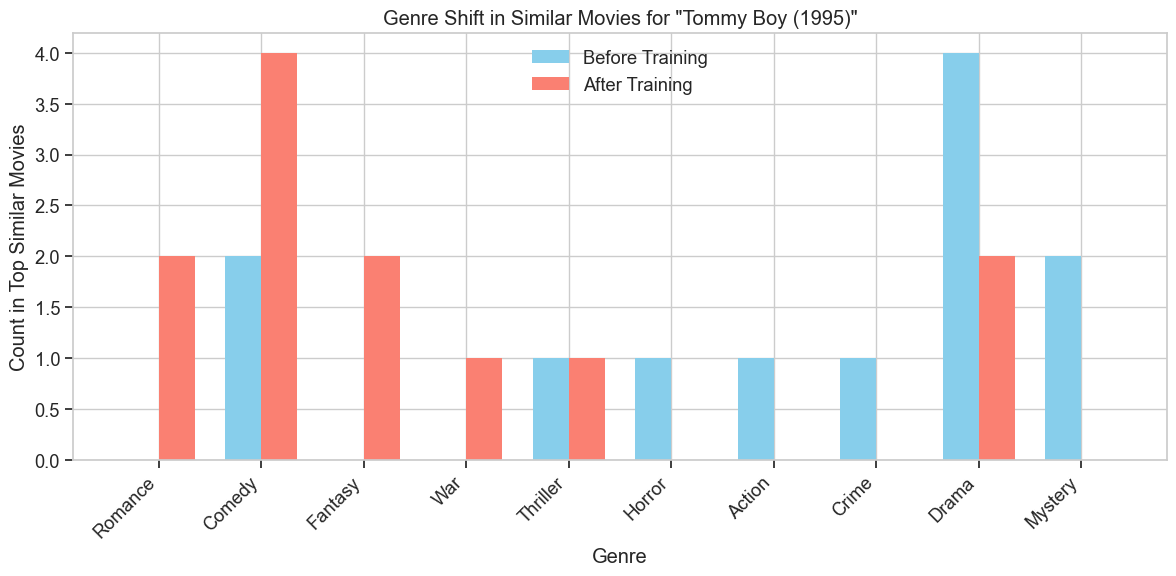


=== Movie with large embedding change: 'Saving Private Ryan (1998)' ===
Change magnitude: 1.837

Similar movies BEFORE vs AFTER training:


,Before Training,Before Similarity,After Training,After Similarity
0,Santa Sangre (1989),0.903,3 Ninjas: High Noon On Mega Mountain (1998),0.979
1,Dunkirk (2017),0.875,Bull Durham (1988),0.978
2,Babylon 5: The Gathering (1993),0.871,"Lock, Stock & Two Smoking Barrels (1998)",0.977
3,Rocky Balboa (2006),0.861,"Angry Red Planet, The (1959)",0.975
4,"Better Tomorrow II, A (Ying hung boon sik II) ...",0.858,"Muppet Christmas Carol, The (1992)",0.972


Movies in common before/after: 0 out of 5
Number of recommendations that changed: 5

Genres in similar movies BEFORE training: Horror, Drama, Thriller, Action, Crime, War, Mystery, Sci-Fi
Genres in similar movies AFTER training: Romance, Drama, Action, Crime, Thriller, Sci-Fi, Musical, Comedy, Children


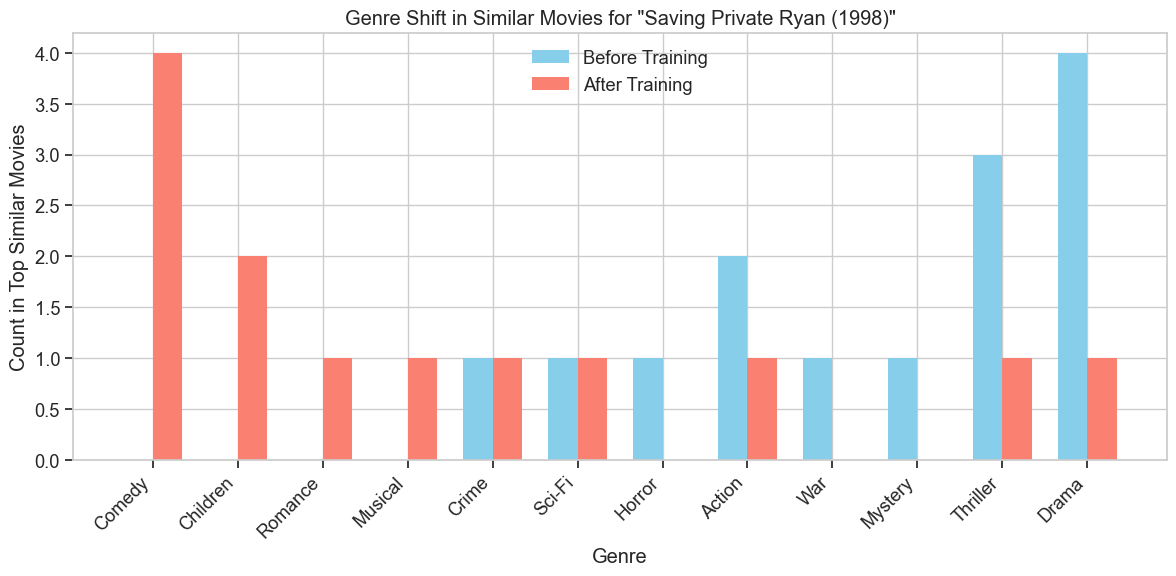


=== Movie with large embedding change: 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)' ===
Change magnitude: 1.814

Similar movies BEFORE vs AFTER training:


,Before Training,Before Similarity,After Training,After Similarity
0,"Ladykillers, The (2004)",0.915,Indiana Jones and the Last Crusade (1989),0.980
1,War Horse (2011),0.911,Die Hard (1988),0.980
2,Sherlock Holmes and the Secret Weapon (1942),0.899,Hoop Dreams (1994),0.969
3,Mr. Deeds (2002),0.880,Just Like Heaven (2005),0.965
4,True Lies (1994),0.871,Muppets From Space (1999),0.962


Movies in common before/after: 0 out of 5
Number of recommendations that changed: 5

Genres in similar movies BEFORE training: Romance, Drama, Crime, Thriller, Action, War, Mystery, Comedy, Adventure
Genres in similar movies AFTER training: Romance, Documentary, Crime, Thriller, Action, Comedy, Children, Fantasy, Adventure


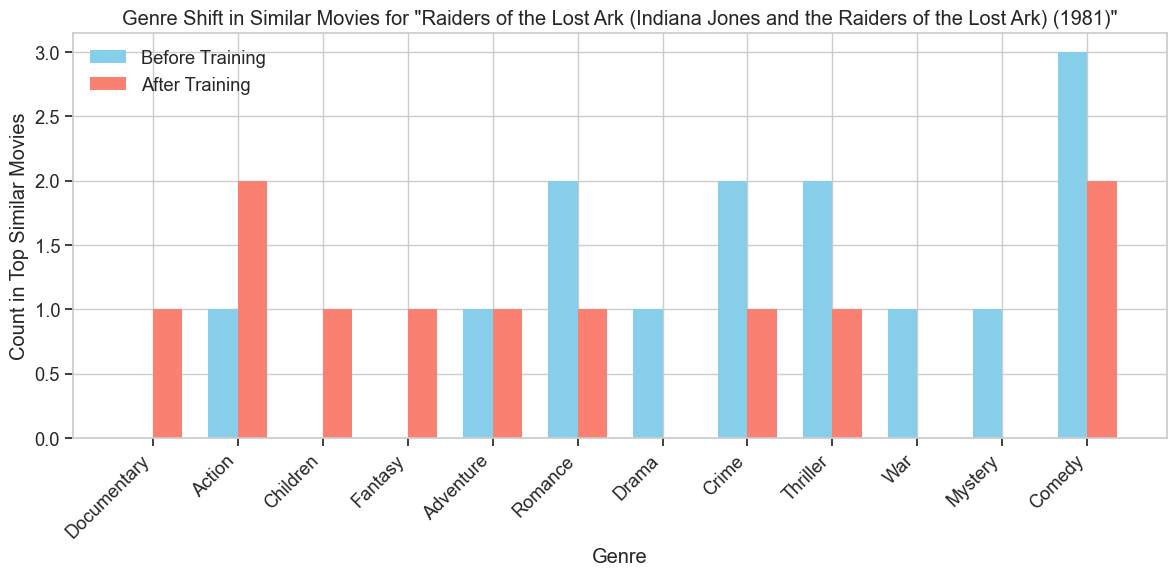


Visualizing embedding space changes for movies with largest shifts...


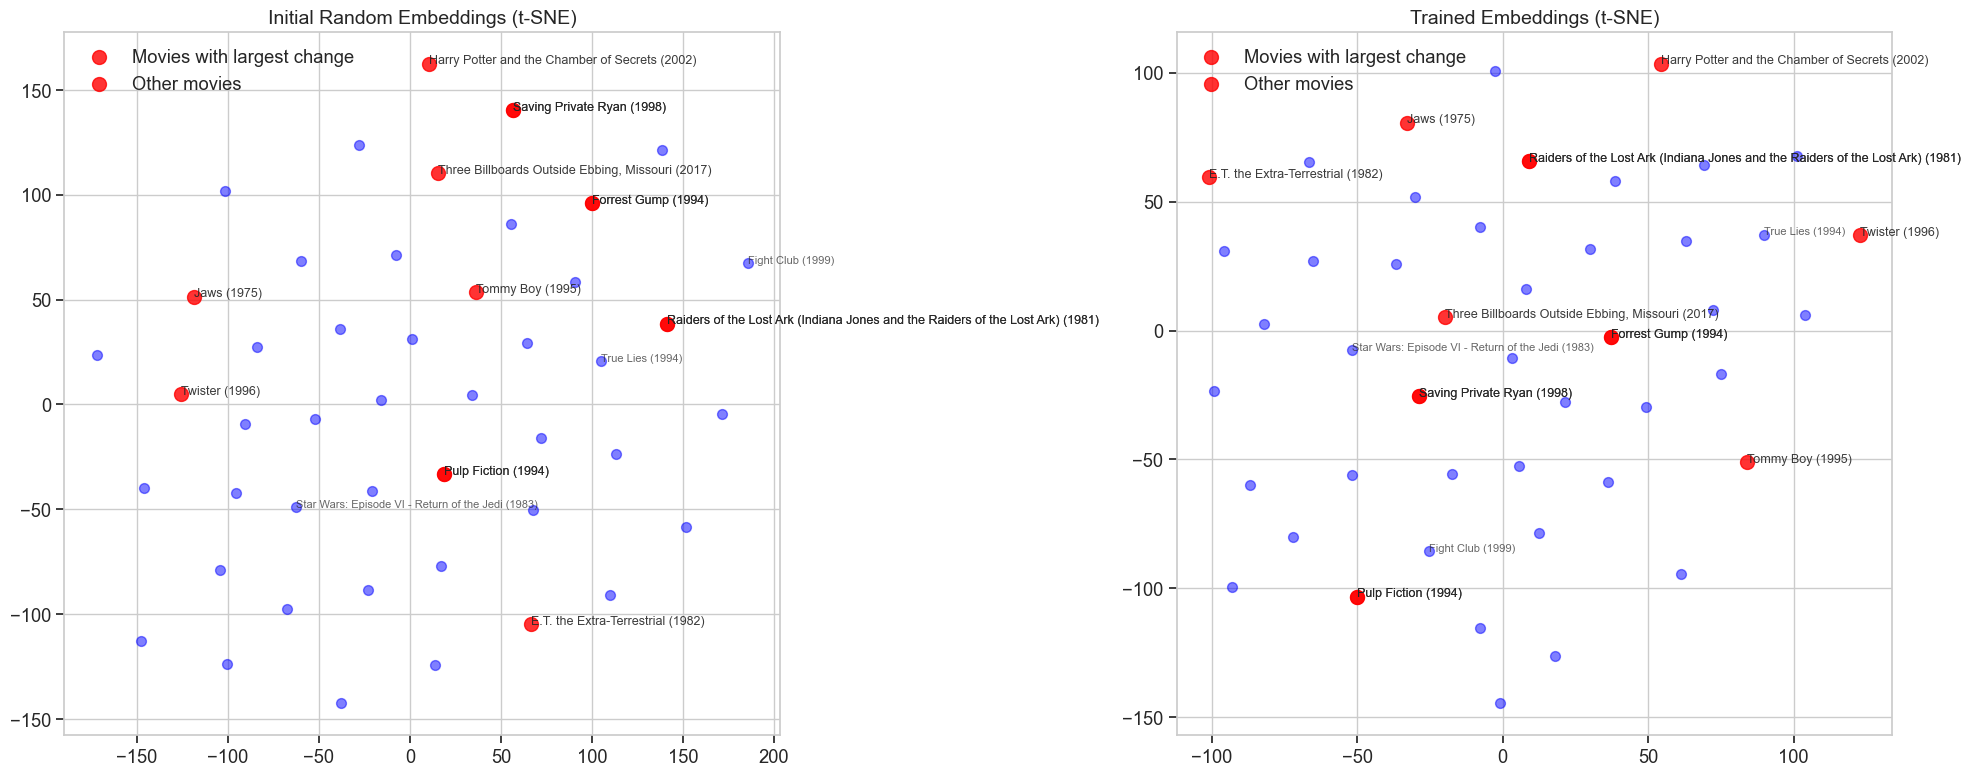


Analyzing similarity matrix changes...


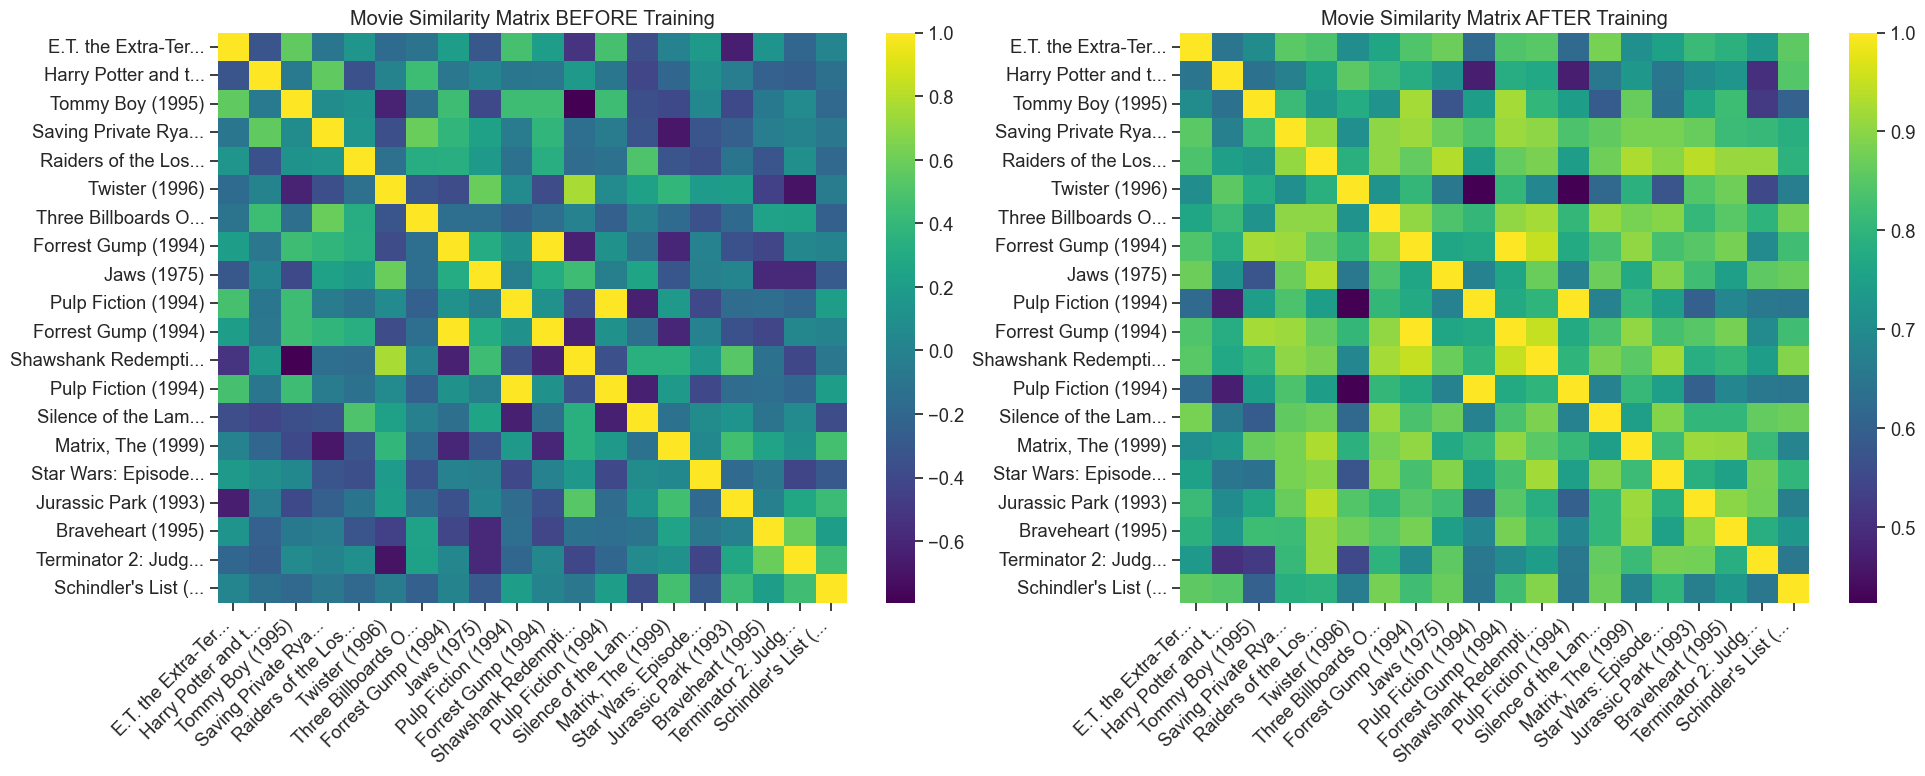

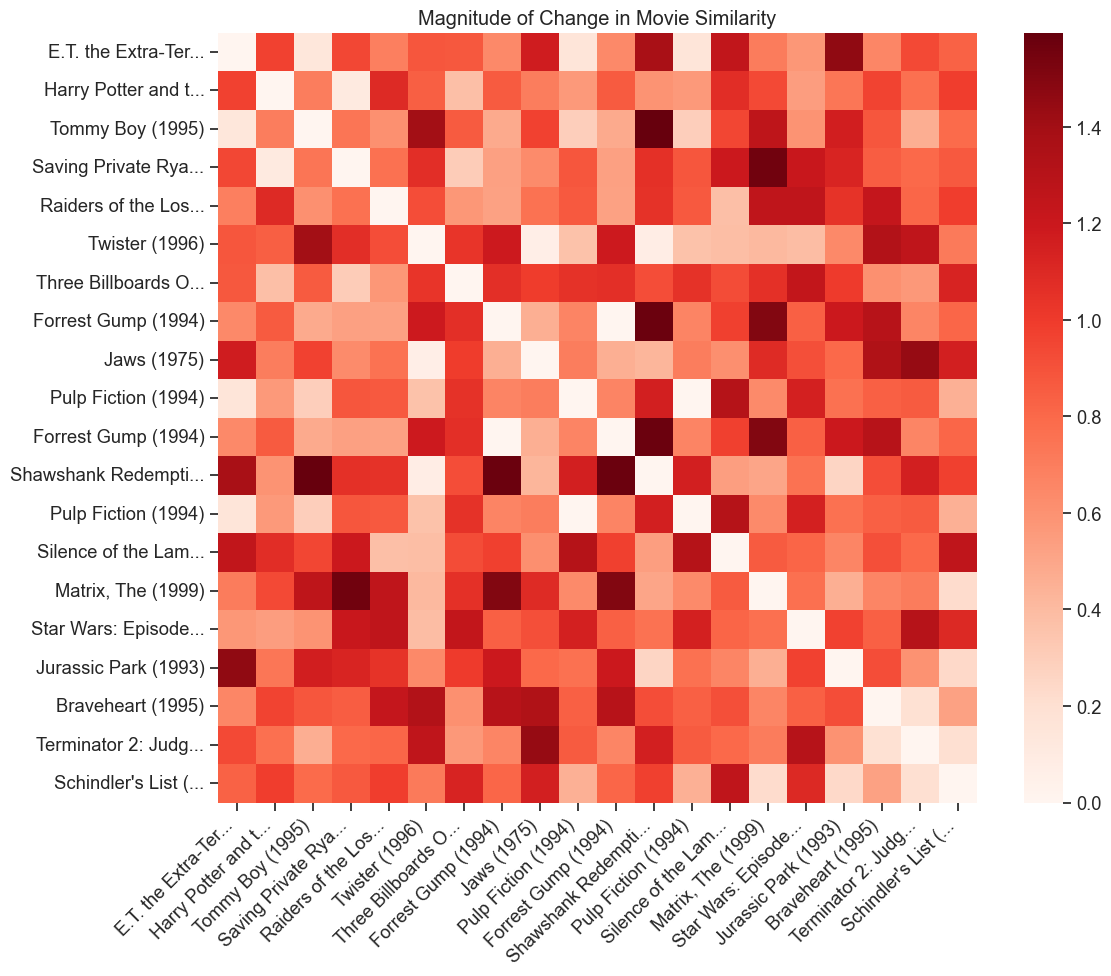


Analysis Complete: Matrix Factorization with Focus on Largest Embedding Changes


In [65]:


# 3. Train the Model (Gradient Descent)
print("\n" + "="*50)
print("Training model...")
print("="*50)

train_loss_history = []
test_loss_history = []  # Track test loss during training

for epoch in range(EPOCHS):
    total_loss = 0
    for _, row in train_df.iterrows():
        user_idx = int(row['userIdx'])
        movie_idx = int(row['movieIdx'])
        rating = row['rating']
        
        # Predicted rating (dot product of user and movie embeddings)
        pred_rating = np.dot(user_embeddings[user_idx], movie_embeddings[movie_idx])
        error = rating - pred_rating
        
        # Update embeddings using gradient descent
        user_grad = error * movie_embeddings[movie_idx] - REGULARIZATION * user_embeddings[user_idx]
        movie_grad = error * user_embeddings[user_idx] - REGULARIZATION * movie_embeddings[movie_idx]
        
        user_embeddings[user_idx] += LEARNING_RATE * user_grad
        movie_embeddings[movie_idx] += LEARNING_RATE * movie_grad
        
        # Compute loss for this example
        total_loss += error ** 2
    
    avg_train_loss = total_loss / len(train_df)
    train_loss_history.append(avg_train_loss)
    
    # Compute test loss for this epoch
    test_loss = compute_test_loss(test_df, user_embeddings, movie_embeddings)
    test_loss_history.append(test_loss)
    
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss:.4f}, Test Loss: {test_loss:.4f}")

# Plot training and test loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Training Loss', marker='o', linewidth=2)
plt.plot(test_loss_history, label='Test Loss', marker='x', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Test Loss Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Find similar movies after training
print("\n" + "="*50)
print("Analyzing movie similarities AFTER training...")
print("="*50)

after_similarities = {}
for movie in valid_example_movies:
    print(f"\nMovies similar to '{movie}' AFTER training:")
    similar = find_similar_movies(movie, movie_embeddings)
    after_similarities[movie] = similar
    display(similar)

# Compare before and after similarities
print("\n" + "="*50)
print("Comparing recommendations before and after training...")
print("="*50)

for movie in valid_example_movies:
    print(f"\n=== Comparison for '{movie}' ===")
    
    # Get before and after dataframes
    before_df = before_similarities[movie]
    after_df = after_similarities[movie]
    
    # Check if we have valid dataframes
    if isinstance(before_df, str) or isinstance(after_df, str):
        print("Could not compare - movie not found.")
        continue
    
    # Create side-by-side comparison
    compare_df = pd.DataFrame({
        'Before Training': before_df['title'].tolist(),
        'Before Similarity': before_df['similarity'].round(3).tolist(),
        'After Training': after_df['title'].tolist(),
        'After Similarity': after_df['similarity'].round(3).tolist()
    })
    
    display(compare_df)
    
    # Check overlap in recommendations
    before_titles = set(before_df['title'])
    after_titles = set(after_df['title'])
    overlap = before_titles.intersection(after_titles)
    print(f"Overlap in recommendations: {len(overlap)} out of {len(before_df)}")
    if overlap:
        print("Common recommendations:", list(overlap))

# 4. Identify movies with largest embedding changes
print("\n" + "="*50)
print("Finding movies with largest embedding changes...")
print("="*50)

# Compute the magnitude of change for each movie embedding
embedding_changes = np.linalg.norm(movie_embeddings - initial_movie_embeddings, axis=1)

# Get indices of movies with largest changes and map to movie IDs
top_changed_indices = np.argsort(embedding_changes)[::-1][:10]
top_changed_movie_ids = [list(movie_id_map.keys())[list(movie_id_map.values()).index(idx)] for idx in top_changed_indices]

# Create dataframe with movie info and change magnitudes
changed_movies_data = []
for idx, movie_id in zip(top_changed_indices, top_changed_movie_ids):
    movie_info = movies_df[movies_df['movieId'] == movie_id]
    if not movie_info.empty:
        changed_movies_data.append({
            'movieId': movie_id,
            'title': movie_info.iloc[0]['title'],
            'genres': movie_info.iloc[0]['genres'],
            'change': embedding_changes[idx]
        })

changed_movies_df = pd.DataFrame(changed_movies_data)
changed_movies_df = changed_movies_df.sort_values('change', ascending=False)

print("\nMovies with largest embedding changes during training:")
display(changed_movies_df)

# Visualize embedding changes
plt.figure(figsize=(12, 6))
bars = plt.barh(changed_movies_df['title'], changed_movies_df['change'], color='skyblue')

# Add values to the end of each bar
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{width:.3f}', ha='left', va='center')

plt.xlabel('Magnitude of Embedding Change')
plt.title('Movies with Largest Embedding Changes During Training')
plt.tight_layout()
plt.show()

# 5. Analyze similarity changes for movies with largest embedding changes
print("\n" + "="*50)
print("Analyzing similarity changes for movies with largest embedding shifts...")
print("="*50)

largest_change_similarities = {}

# Get the top 5 movies with largest changes
top_5_changed_movies = changed_movies_df.head(5)

for _, movie_row in top_5_changed_movies.iterrows():
    movie_id = movie_row['movieId']
    movie_title = movie_row['title']
    
    print(f"\n=== Movie with large embedding change: '{movie_title}' ===")
    print(f"Change magnitude: {movie_row['change']:.3f}")
    
    # Find similar movies before training
    movie_idx = movie_id_map[movie_id]
    
    # Create a function to get similar movies by ID (not title)
    def find_similar_by_id(movie_id, movie_emb, top_n=5):
        movie_idx = movie_id_map[movie_id]
        target_embedding = movie_emb[movie_idx].reshape(1, -1)
        
        similarities = []
        for idx, mid in enumerate(movie_id_map.keys()):
            if idx != movie_idx:  # Skip the target movie itself
                sim = cosine_similarity(target_embedding, movie_emb[idx].reshape(1, -1))[0][0]
                similarities.append((mid, sim))
        
        similarities.sort(key=lambda x: x[1], reverse=True)
        
        result = []
        for mid, sim in similarities[:top_n]:
            movie_info = movies_df[movies_df['movieId'] == mid]
            if not movie_info.empty:
                result.append({
                    'movieId': mid,
                    'title': movie_info.iloc[0]['title'],
                    'genres': movie_info.iloc[0]['genres'],
                    'similarity': sim
                })
        
        return pd.DataFrame(result)
    
    # Get before and after similarities
    before_similar = find_similar_by_id(movie_id, initial_movie_embeddings)
    after_similar = find_similar_by_id(movie_id, movie_embeddings)
    
    # Store for later use
    largest_change_similarities[movie_title] = {
        'before': before_similar,
        'after': after_similar
    }
    
    # Create side-by-side comparison
    print("\nSimilar movies BEFORE vs AFTER training:")
    compare_df = pd.DataFrame({
        'Before Training': before_similar['title'].tolist(),
        'Before Similarity': before_similar['similarity'].round(3).tolist(),
        'After Training': after_similar['title'].tolist(),
        'After Similarity': after_similar['similarity'].round(3).tolist()
    })
    
    display(compare_df)
    
    # Calculate similarity change statistics
    before_titles = set(before_similar['title'])
    after_titles = set(after_similar['title'])
    overlap = before_titles.intersection(after_titles)
    similarity_change = len(before_titles - after_titles)
    
    print(f"Movies in common before/after: {len(overlap)} out of {len(before_similar)}")
    print(f"Number of recommendations that changed: {similarity_change}")
    
    # Compare genres before and after
    before_genres = set(genre for genres in before_similar['genres'] for genre in genres.split('|'))
    after_genres = set(genre for genres in after_similar['genres'] for genre in genres.split('|'))
    
    print("\nGenres in similar movies BEFORE training:", ', '.join(before_genres))
    print("Genres in similar movies AFTER training:", ', '.join(after_genres))
    
    # Visualize the genre shifts
    before_genre_count = {}
    after_genre_count = {}
    
    for genres in before_similar['genres']:
        for genre in genres.split('|'):
            before_genre_count[genre] = before_genre_count.get(genre, 0) + 1
            
    for genres in after_similar['genres']:
        for genre in genres.split('|'):
            after_genre_count[genre] = after_genre_count.get(genre, 0) + 1
    
    # All genres from both before and after
    all_genres = set(before_genre_count.keys()) | set(after_genre_count.keys())
    
    # Create dataframe for plotting
    genre_shift_data = []
    for genre in all_genres:
        genre_shift_data.append({
            'Genre': genre,
            'Before': before_genre_count.get(genre, 0),
            'After': after_genre_count.get(genre, 0),
            'Change': after_genre_count.get(genre, 0) - before_genre_count.get(genre, 0)
        })
    
    genre_shift_df = pd.DataFrame(genre_shift_data)
    genre_shift_df = genre_shift_df.sort_values('Change', ascending=False)
    
    # Plot genre shift
    plt.figure(figsize=(12, 6))
    
    x = np.arange(len(genre_shift_df))
    width = 0.35
    
    plt.bar(x - width/2, genre_shift_df['Before'], width, label='Before Training', color='skyblue')
    plt.bar(x + width/2, genre_shift_df['After'], width, label='After Training', color='salmon')
    
    plt.xlabel('Genre')
    plt.ylabel('Count in Top Similar Movies')
    plt.title(f'Genre Shift in Similar Movies for "{movie_title}"')
    plt.xticks(x, genre_shift_df['Genre'], rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 6. Visualize the embedding space with movies that changed the most
print("\n" + "="*50)
print("Visualizing embedding space changes for movies with largest shifts...")
print("="*50)

from sklearn.manifold import TSNE

# Get embeddings for all movies
all_initial_embeddings = initial_movie_embeddings
all_final_embeddings = movie_embeddings

# Select a subset of movies including the ones with largest changes
vis_movie_count = 50  # Total movies to visualize
remaining_count = vis_movie_count - len(top_changed_indices)

# Get most popular movies for the remaining slots
popular_movie_counts = ratings_df['movieId'].value_counts().head(remaining_count)
popular_movie_ids = popular_movie_counts.index.tolist()
popular_movie_indices = [movie_id_map[mid] for mid in popular_movie_ids if mid in movie_id_map]

# Combine indices for visualization (changed movies + popular ones)
vis_indices = list(top_changed_indices) + popular_movie_indices
vis_indices = vis_indices[:vis_movie_count]  # Ensure we don't exceed the count

# Extract embeddings for these movies
initial_embeddings_subset = all_initial_embeddings[vis_indices]
final_embeddings_subset = all_final_embeddings[vis_indices]

# Use t-SNE to reduce to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(vis_indices)-1))
initial_tsne = tsne.fit_transform(initial_embeddings_subset)
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(vis_indices)-1))
final_tsne = tsne.fit_transform(final_embeddings_subset)

# Get movie titles and mark those with large changes
movie_titles = []
movie_genres = []
is_large_change = []

for idx in vis_indices:
    movie_id = list(movie_id_map.keys())[list(movie_id_map.values()).index(idx)]
    movie_info = movies_df[movies_df['movieId'] == movie_id]
    
    if not movie_info.empty:
        movie_titles.append(movie_info.iloc[0]['title'])
        # Get primary genre
        genres = movie_info.iloc[0]['genres'].split('|')
        movie_genres.append(genres[0] if genres else "Unknown")
        # Mark as large change if in top_changed_indices
        is_large_change.append(idx in top_changed_indices)

# Create subplots to compare before and after
plt.figure(figsize=(20, 8))

# Plot initial embeddings
plt.subplot(1, 2, 1)
for i, (x, y) in enumerate(initial_tsne):
    if is_large_change[i]:
        plt.scatter(x, y, color='red', s=100, alpha=0.8)
        plt.annotate(movie_titles[i], (x, y), fontsize=9, alpha=0.9)
    else:
        plt.scatter(x, y, color='blue', s=50, alpha=0.5)
        if i % 10 == 0:  # Only label some of the regular movies
            plt.annotate(movie_titles[i], (x, y), fontsize=8, alpha=0.7)

plt.title('Initial Random Embeddings (t-SNE)', fontsize=14)
plt.legend(['Movies with largest change', 'Other movies'])

# Plot final embeddings
plt.subplot(1, 2, 2)
for i, (x, y) in enumerate(final_tsne):
    if is_large_change[i]:
        plt.scatter(x, y, color='red', s=100, alpha=0.8)
        plt.annotate(movie_titles[i], (x, y), fontsize=9, alpha=0.9)
    else:
        plt.scatter(x, y, color='blue', s=50, alpha=0.5)
        if i % 10 == 0:  # Only label some of the regular movies
            plt.annotate(movie_titles[i], (x, y), fontsize=8, alpha=0.7)

plt.title('Trained Embeddings (t-SNE)', fontsize=14)
plt.legend(['Movies with largest change', 'Other movies'])

plt.tight_layout()
plt.show()

# 7. Calculate and plot similarity matrix changes
print("\n" + "="*50)
print("Analyzing similarity matrix changes...")
print("="*50)

# Get a subset of movies including those with large changes
sim_matrix_size = 20

sim_indices = top_changed_indices[:10].tolist()  # 10 movies with largest changes

# Add some popular movies
remaining_count = sim_matrix_size - len(sim_indices)
popular_movie_indices = popular_movie_indices[:remaining_count]
sim_indices.extend(popular_movie_indices)
sim_indices = sim_indices[:sim_matrix_size]  # Ensure we don't exceed the count

# Extract embeddings for these movies
sim_embeddings_before = initial_movie_embeddings[sim_indices]
sim_embeddings_after = movie_embeddings[sim_indices]

# Calculate similarity matrices
sim_matrix_before = cosine_similarity(sim_embeddings_before)
sim_matrix_after = cosine_similarity(sim_embeddings_after)

# Get movie titles for these indices
sim_movie_titles = []
for idx in sim_indices:
    movie_id = list(movie_id_map.keys())[list(movie_id_map.values()).index(idx)]
    movie_info = movies_df[movies_df['movieId'] == movie_id]
    if not movie_info.empty:
        # Truncate long titles for better display
        title = movie_info.iloc[0]['title']
        if len(title) > 20:
            title = title[:18] + '...'
        sim_movie_titles.append(title)
    else:
        sim_movie_titles.append(f"Movie {idx}")

# Plot similarity matrices
plt.figure(figsize=(20, 8))

# Before training
plt.subplot(1, 2, 1)
sns.heatmap(sim_matrix_before, annot=False, cmap='viridis', 
            xticklabels=sim_movie_titles, yticklabels=sim_movie_titles)
plt.title('Movie Similarity Matrix BEFORE Training')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# After training
plt.subplot(1, 2, 2)
sns.heatmap(sim_matrix_after, annot=False, cmap='viridis', 
            xticklabels=sim_movie_titles, yticklabels=sim_movie_titles)
plt.title('Movie Similarity Matrix AFTER Training')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

# Calculate the difference in similarity matrices
sim_matrix_diff = np.abs(sim_matrix_after - sim_matrix_before)

# Plot the difference
plt.figure(figsize=(12, 10))
sns.heatmap(sim_matrix_diff, annot=False, cmap='Reds', 
            xticklabels=sim_movie_titles, yticklabels=sim_movie_titles)
plt.title('Magnitude of Change in Movie Similarity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("Analysis Complete: Matrix Factorization with Focus on Largest Embedding Changes")
print("="*50)